Read in images, maybe look for the most common colour? Or look at borders and then each image only has that value, then use that as a classifier to try and guess fitzpatrick_skin_type or something else
Potentially look for dataset of skin tones with Monk Skin Tone
- https://en.wikipedia.org/wiki/Fitzpatrick_scale
- https://en.wikipedia.org/wiki/Monk_Skin_Tone_Scale

- https://skintone.google/mste-dataset
- https://github.com/google-research-datasets/scin

In [1]:
import cv2
from skimage import io, color
import numpy as np
import math
import os
import glob
from tqdm import tqdm
import pandas as pd


For each image, work out the modal colour of the border and then make a classifier that takes that in and the Fitzgerland score from the spreadsheet and does that. First do it for all fitzgeralds, then for light vs dark

30 < L* < 80
0 < a* < 20
5 < b* < 25

In [2]:
def lab_to_ITA(row):
    if 30<row[0]<80 == False:
        return np.nan
    elif 0<row[1]<20 == False:
        return np.nan
    elif 5<row[2]<25 == False:
        return np.nan
    else:
        result=math.atan((row[0]-50)/row[2])*180/math.pi
        return result

def Modal_Colour(ITA, precision):
    histo= np.histogram(ITA, bins=precision)
    histo = histo[0][1:], histo[1][1:]
    mode_index = np.argmax(histo[0])

    return mode_index, histo

def image_to_mode_border(ImagePath, precision):
    rgb = io.imread(ImagePath)
    lab = color.rgb2lab(rgb)

    lab_ita = [lab_to_ITA(row) for row in lab[0]]
    mode_index, histo = Modal_Colour(lab_ita, precision)

    return mode_index

Below labels all the data, takes ages to run, don't use it unless you're relabelling stuff.

In [3]:
break
# Path to the ISIC-images folder
folder_path = 'myimages'

# List to store the outputs
output_list = []
ISIC_ID=[]
print(os.listdir(folder_path))
# Iterate over each image in the folder
progess=0
file_count = len(glob.glob(os.path.join(folder_path, '*.JPG')))
print(file_count)

# Iterate over each image in the folder
progress = tqdm(total=file_count, desc="Processing Images")

for filename in os.listdir(folder_path):
    if filename.endswith(".JPG"):
        file=filename.replace(".JPG", "")
        ISIC_ID.append(file)
        # Read the image
        image_path = os.path.join(folder_path, filename)
        
        # Apply the function and store the output
        output = image_to_mode_border(image_path, 50)
        output_list.append(output)
        
        # Update the progress bar
        progress.update(1)

# Close the progress bar
progress.close()

print(output_list)

df = pd.DataFrame({'isic_id': ISIC_ID, 'SkinTone': output_list})

# Save the DataFrame as a CSV file
df.to_csv('output_list2.csv', index=False)
df.head()


SyntaxError: 'break' outside loop (3685818934.py, line 1)

In [4]:
metadata = pd.read_csv('myimages/metadata.csv')
output=pd.read_csv('output_list2.csv')
metadata.head()

,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,dermoscopic_type,...,mel_thick_mm,mel_type,mel_ulcer,melanocytic,nevus_type,patient_id,personal_hx_mm,pixels_x,pixels_y,sex
0,ISIC_7559201,Memorial Sloan Kettering Cancer Center,CC-BY,2497.0,55.0,anterior torso,benign,6.6,NaN,contact non-polarized,...,NaN,NaN,NaN,True,NaN,IP_1238256,True,3264,2448,female
1,ISIC_0485014,Memorial Sloan Kettering Cancer Center,CC-BY,1.0,45.0,lower extremity,benign,NaN,NaN,contact non-polarized,...,NaN,NaN,NaN,True,NaN,IP_3227071,NaN,6000,4000,female
2,ISIC_5257439,Memorial Sloan Kettering Cancer Center,CC-BY,2360.0,40.0,lateral torso,benign,4.2,NaN,NaN,...,NaN,NaN,NaN,True,NaN,IP_7407753,True,3264,2448,female
3,ISIC_2989732,Memorial Sloan Kettering Cancer Center,CC-BY,78.0,80.0,anterior torso,benign,NaN,NaN,non-contact polarized,...,NaN,NaN,NaN,True,NaN,IP_2597637,NaN,6000,4000,male
4,ISIC_5638210,Memorial Sloan Kettering Cancer Center,CC-BY,78.0,80.0,anterior torso,benign,NaN,NaN,contact non-polarized,...,NaN,NaN,NaN,True,NaN,IP_2597637,NaN,6000,4000,male


In [5]:
SkinClassifier = pd.merge(metadata, output, on='isic_id')
SkinClassifier.head()

,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,dermoscopic_type,...,mel_type,mel_ulcer,melanocytic,nevus_type,patient_id,personal_hx_mm,pixels_x,pixels_y,sex,SkinTone
0,ISIC_7559201,Memorial Sloan Kettering Cancer Center,CC-BY,2497.0,55.0,anterior torso,benign,6.6,NaN,contact non-polarized,...,NaN,NaN,True,NaN,IP_1238256,True,3264,2448,female,48
1,ISIC_0485014,Memorial Sloan Kettering Cancer Center,CC-BY,1.0,45.0,lower extremity,benign,NaN,NaN,contact non-polarized,...,NaN,NaN,True,NaN,IP_3227071,NaN,6000,4000,female,13
2,ISIC_5257439,Memorial Sloan Kettering Cancer Center,CC-BY,2360.0,40.0,lateral torso,benign,4.2,NaN,NaN,...,NaN,NaN,True,NaN,IP_7407753,True,3264,2448,female,44
3,ISIC_2989732,Memorial Sloan Kettering Cancer Center,CC-BY,78.0,80.0,anterior torso,benign,NaN,NaN,non-contact polarized,...,NaN,NaN,True,NaN,IP_2597637,NaN,6000,4000,male,47
4,ISIC_5638210,Memorial Sloan Kettering Cancer Center,CC-BY,78.0,80.0,anterior torso,benign,NaN,NaN,contact non-polarized,...,NaN,NaN,True,NaN,IP_2597637,NaN,6000,4000,male,40


In [6]:
def fitzpatrick_converter(entry):
    if entry == "I":
        return "1"
    elif entry == "II":
        return "2"
    elif entry == "III":
        return "3"
    elif entry == "IV":
        return "4"
    elif entry == "V":
        return "5"
    elif entry == "VI":
        return "6"
    else:
        return "Error"
def fitzpatrick_binary(entry):
    if entry in ["1", "2"]:
        return "0"
    elif entry in ["3", "4", "5", "6"]:
        return "1"
    else:
        return "Error"

<Axes: xlabel='fitzpatrick_skin_type'>

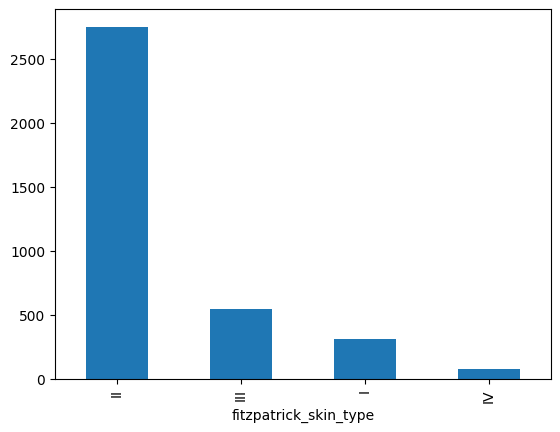

In [7]:
SkinClassifier['fitzpatrick_skin_type'].value_counts().plot(kind="bar")

In [8]:
SkinClassifier['ToneMult'] = SkinClassifier['fitzpatrick_skin_type'].apply(fitzpatrick_converter)
SkinClassifier["ToneBinary"]=SkinClassifier['ToneMult'].apply(fitzpatrick_binary)


<Axes: xlabel='ToneMult'>

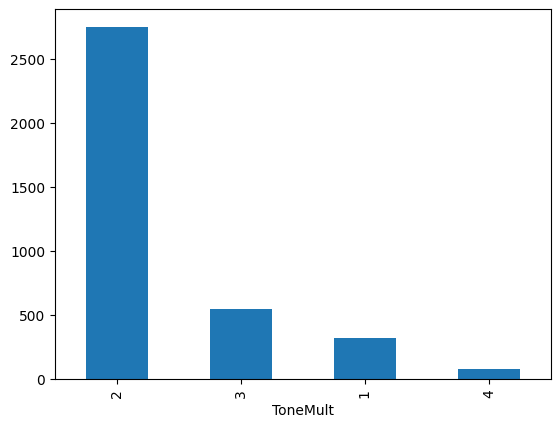

In [9]:
SkinClassifier["ToneMult"].value_counts().plot(kind="bar")

<Axes: xlabel='ToneBinary'>

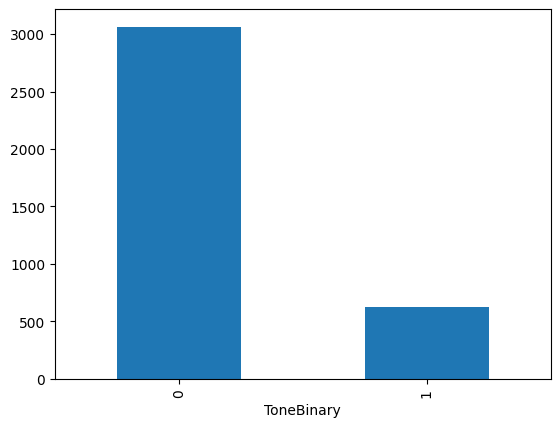

In [10]:
SkinClassifier["ToneBinary"].value_counts().plot(kind="bar")


In [11]:
ClassDF=SkinClassifier[['isic_id','ToneBinary','ToneMult','SkinTone']]
ClassDF = ClassDF[ClassDF['ToneBinary'] != 'Error']

ClassDF.head()

,isic_id,ToneBinary,ToneMult,SkinTone
0,ISIC_7559201,1,4,48
1,ISIC_0485014,0,1,13
2,ISIC_5257439,0,2,44
3,ISIC_2989732,0,2,47
4,ISIC_5638210,0,2,40


<Axes: xlabel='SkinTone', ylabel='Count'>

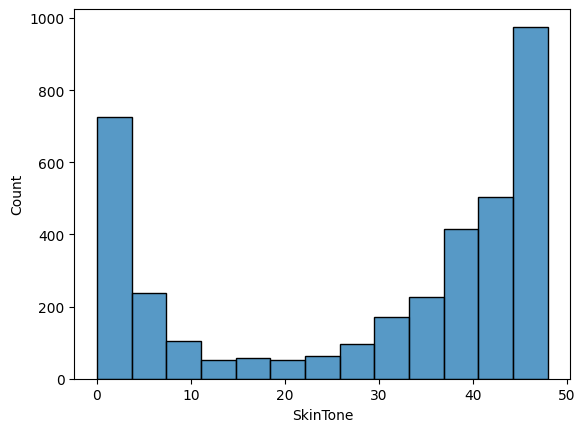

In [18]:
import seaborn as sns
sns.histplot(ClassDF['SkinTone'])

<Axes: xlabel='SkinTone', ylabel='Density'>

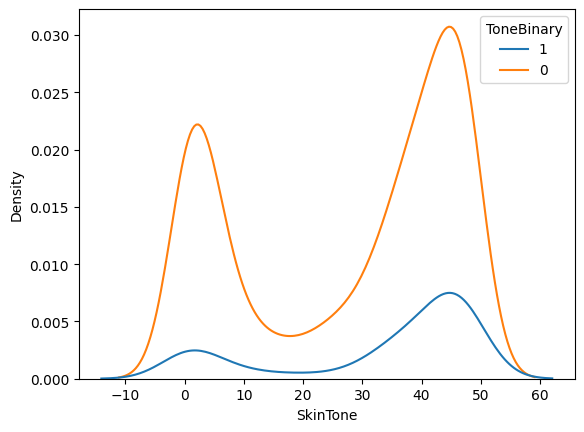

In [20]:
sns.kdeplot(data=ClassDF, x='SkinTone', hue='ToneBinary')

In [ ]:
nan_values = ClassDF.isna().sum()
print(nan_values)


isic_id       0
ToneBinary    0
ToneMult      0
SkinTone      0
dtype: int64


In [ ]:
X = ClassDF["SkinTone"]
y = ClassDF['ToneBinary']
y.value_counts()
len(X)
# Got some fixing to do


3685

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.25)
X_train = X_train.to_frame()
X_test = X_test.to_frame()
y_train = y_train.to_frame()
y_test = y_test.to_frame()

from sklearn.preprocessing import StandardScaler

ss_train = StandardScaler()
X_train = ss_train.fit_transform(X_train)

ss_test = StandardScaler()
X_test = ss_test.fit_transform(X_test)

In [ ]:
models = {}

# Logistic Regression
#from sklearn.linear_model import LogisticRegression
#models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()
#SVM is best :)




# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# # Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score


accuracy, precision, recall, predictions = {}, {}, {}, {}

for key in models.keys():
    
    # Fit the classifier
    models[key].fit(X_train, y_train)
    
    # Make predictions
    predictions = models[key].predict(X_test)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test, average='weighted')
    recall[key] = recall_score(predictions, y_test, average='weighted')
    

c:\Users\hd15639\AppData\Local\anaconda3\envs\SkinTone\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hd15639\AppData\Local\anaconda3\envs\SkinTone\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\hd15639\AppData\Local\anaconda3\envs\SkinTone\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hd15639\AppData\Local\anaconda3\envs\SkinTone\Lib\site-packages\sklearn\metrics\_classif

In [ ]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model

,Accuracy,Precision,Recall
Support Vector Machines,0.827549,1.0,0.827549
Decision Trees,0.827549,1.0,0.827549
Random Forest,0.827549,1.0,0.827549
Naive Bayes,0.827549,1.0,0.827549
K-Nearest Neighbor,0.827549,1.0,0.827549


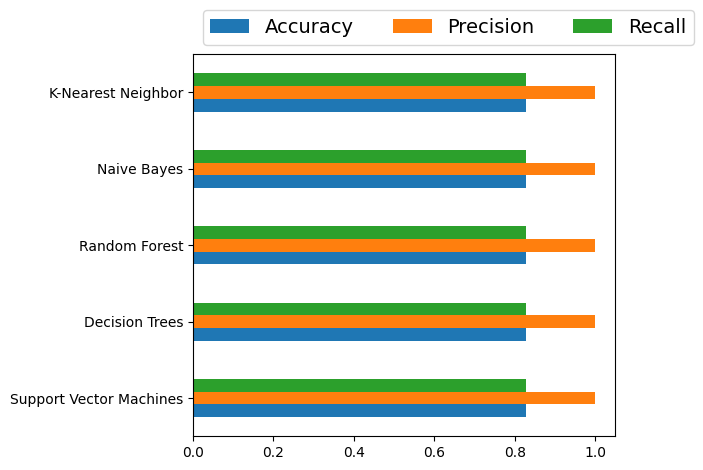

In [ ]:
ax = df_model.plot.barh()
ax.legend(
    ncol=len(models.keys()), 
    bbox_to_anchor=(0, 1), 
    loc='lower left', 
    prop={'size': 14}
)
plt.tight_layout()

In [ ]:
ClassDF['ToneBinary'].value_counts()
print(3063/(3063+622))


0.8312075983717775


In [ ]:
ClassDF["SVM Prediction"]=models['Support Vector Machines'].predict(ClassDF["SkinTone"].to_frame())
ClassDF.head()

c:\Users\hd15639\AppData\Local\anaconda3\envs\SkinTone\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


,isic_id,ToneBinary,ToneMult,SkinTone,SVM Prediction
0,ISIC_7559201,1,4,48,1
1,ISIC_0485014,0,1,13,1
2,ISIC_5257439,0,2,44,1
3,ISIC_2989732,0,2,47,1
4,ISIC_5638210,0,2,40,1


In [ ]:
FalseNegatives = ClassDF[(ClassDF["SVM Prediction"] == "0") & (ClassDF["ToneBinary"] == "1")]
FalseNegatives.to_csv("FalseNegatives.csv")
print(FalseNegatives)

           isic_id ToneBinary ToneMult  SkinTone SVM Prediction
14    ISIC_4691636          1        4         5              0
22    ISIC_5921373          1        4         0              0
31    ISIC_1028529          1        4         0              0
35    ISIC_6779786          1        4         1              0
44    ISIC_7727119          1        4         0              0
...            ...        ...      ...       ...            ...
3563  ISIC_9863562          1        3         4              0
3590  ISIC_3481768          1        3         5              0
3607  ISIC_0202120          1        3         2              0
3615  ISIC_3797573          1        3         3              0
3650  ISIC_9127114          1        3         6              0

[111 rows x 5 columns]


In [ ]:
import matplotlib.pyplot as plt
import os
break
# Get the isic_id column from the FalseNegatives dataframe
isic_ids = FalseNegatives['isic_id']

# Construct the image paths
image_paths = [os.path.join(folder_path, f"{isic_id}.JPG") for isic_id in isic_ids]

# Display the images
for image_path in image_paths:
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


SyntaxError: 'break' outside loop (2242460848.py, line 3)

- True Positive (TP): The patient is diseased and the model predicts "diseased"
- False Positive (FP): The patient is healthy but the model predicts "diseased"
- True Negative (TN): The patient is healthy and the model predicts "healthy"
- False Negative (FN): The patient is diseased and the model predicts "healthy"

- Accuracy = TP+TN  /  TP + FP + TN + FN = The proportion of guesses that you made that were actually correct
- Precision = TP / TP + FP = The proportion of things you predicted as positive that actually were positive
- Recall = TP / TP + FN = The proportion of things that actually are positive, that you predicted as positive

To do:
- Actually run the code and save it this time you doughnut
- For SVM, output the False Negatives and see what they have in common (predict they're the darker skin tones)
- Maybe just the border this time, you numptee
- A few pixels inside the border 

Table 2 Page 9 of paper in skin tone folder on ITA angle:
30 < L* < 80
0 < a* < 20
5 < b* < 25

Anything outside these ranges is likely not skin. Filter them out first, then look for mode ITA :)